In [40]:
import numpy as np
import scipy.stats
from matplotlib import pyplot as plt
import math

In [41]:
max_cap = 100
n_prices = 100

In [42]:
def F_tau(P,MaxP):
    return (P*(2*MaxP-1-P))/(MaxP*(MaxP-1))

def Create_Rew_Prob_ERew_Matrix(ns,na,N):

    reward_matrix = np.zeros((ns+1,na+1,ns+1))

    trans_prob_mat = np.zeros((ns+1,na+1,ns+1))

    exp_val_mat = np.zeros((ns+1,na+1))

    for s in range(1,ns+1):
        
        for a in range(0,na+1):

            exp_val_hold = []

            for sprime in range(1,s+1):
                
                sold = min(s-sprime,N)

                rew=(sold*a/N)
                reward_matrix[s,a,sprime] = rew

                prob = math.comb(N,sold)*(F_tau(a,na)**(N-sold))*((1-F_tau(a,na))**sold)
                if prob > 1 or prob < 0:
                    print(prob)
                trans_prob_mat[s,a,sprime] = prob
                
                
                exp_val_hold.append(prob*rew)
            
            sold = s

            rew = (sold*a/N)
            reward_matrix[s,a,0] = rew

            prob = 1 - sum(trans_prob_mat[s,a,:])
            trans_prob_mat[s,a,0] = prob

            # if prob > 1 or prob < 0:
            #         print(prob,s,a)

            exp_val_hold.append(prob*rew)
            
            exp_val_mat[s,a] = sum(exp_val_hold)

    return reward_matrix, trans_prob_mat, exp_val_mat




In [43]:
n_actions = 100
n_states = 100
n_customers = 100
R,P,ER = Create_Rew_Prob_ERew_Matrix(n_actions,n_states,n_customers)

best_price = []

for s in range(max_cap+1):
    best_price.append(np.argmax(ER[s,:]))

true_table = np.zeros((max_cap+1,n_prices+1))

gamma=1

for s in range(1,max_cap+1):
    for a in range(n_prices+1):
        true_table[s,a] = ER[s,a] + gamma*sum([ P[s,a,sprime] * np.max(true_table[sprime,:]) for sprime in range(0,s+1)])

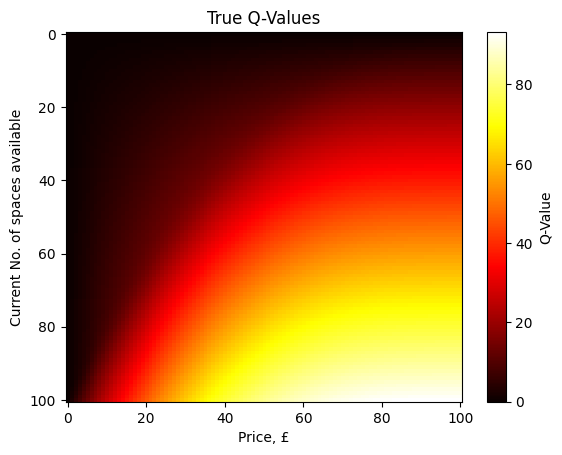

In [44]:
plt.imshow(true_table, cmap='hot',aspect='auto')
plt.xlabel("Price, £")
plt.ylabel("Current No. of spaces available")
plt.colorbar(label = 'Q-Value')
plt.title("True Q-Values")
plt.show()

In [45]:
def Create_Threshold_Basic_Linear(min_price,max_price,amount_of_thresholds):
    y = [max_price - i for i in range(min_price,max_price+1)]
    thresh = np.random.choice(a = range(min_price,max_price+1),
                               p = [i/sum(y) for i in y],
                                 size = amount_of_thresholds)
    return list(thresh)

In [46]:
#step size/ learning rate/ alpha
learn_rate = 0.1

n_episodes = 10**5

n_macro_reps = 30

explore_prob = .1

n_customers = 100

gamma = 1

In [47]:
np.random.seed(11)

reward_norm = np.zeros((n_episodes,n_macro_reps))
regret_norm = np.zeros((n_episodes,n_macro_reps))

for replication in range(n_macro_reps):

    q_table = np.zeros((max_cap+1,n_prices+1)) 

    for ep in range(n_episodes):

        current_capacity = np.random.randint(0,max_cap)

        curr_reward_today = 0

        #choose action at the start of the day
        #Q-learner maximises current estimated value
        #e-Greedy

        #explore
        if np.random.uniform() < explore_prob:
            #random action
            action_price = int(np.random.randint(n_prices+1))
            #action_price = 33
        else:
            #greedy action
            action_price = int(np.argmax(q_table[current_capacity,:]))

        new_capacity = current_capacity

        customer_thresholds = Create_Threshold_Basic_Linear(0,100,n_customers)

        #go through every customer in the day
        for curr_thresh in customer_thresholds:

            #will customer accept price
            if action_price < curr_thresh and new_capacity < max_cap:
                
                #if accepted gain reward for revenue
                curr_reward_today += action_price
                new_capacity +=1

            else: 
                curr_reward_today += 0

        
        #update after every day
        #REWARD = Revenue/customer
        final_reward_today = curr_reward_today/n_customers
        reward_norm[ep,replication] = final_reward_today
        regret_norm[ep,replication] = np.max(ER[max_cap - current_capacity,:]) - final_reward_today
        #Q-Learning iteration
        q_table[current_capacity,action_price] = (1-learn_rate) * q_table[current_capacity,action_price] + learn_rate *( final_reward_today + gamma * np.max(q_table[new_capacity,:]) )



In [48]:
np.random.seed(11)

reward_aug_action = np.zeros((n_episodes,n_macro_reps))
regret_aug_action = np.zeros((n_episodes,n_macro_reps))

for replication in range(n_macro_reps):

    q_table_aug_action = np.zeros((max_cap+1,n_prices+1)) 

    for ep in range(n_episodes):

        current_capacity = np.random.randint(0,max_cap)

        curr_reward_today = 0

        #choose action at the start of the day
        #Q-learner maximises current estimated value
        #e-Greedy

        #explore
        if np.random.uniform() < explore_prob:
            #random action
            action_price = int(np.random.randint(n_prices+1))
            #action_price = 33
        else:
            #greedy action
            action_price = int(np.argmax(q_table_aug_action[current_capacity,:]))

        new_capacity = current_capacity

        customer_thresholds = Create_Threshold_Basic_Linear(0,100,n_customers)

        #go through every customer in the day
        for curr_thresh in customer_thresholds:

            #will customer accept price
            if action_price < curr_thresh and new_capacity < max_cap:
                
                #if accepted gain reward for revenue
                curr_reward_today += action_price
                new_capacity +=1

            else: 
                curr_reward_today += 0

        
        #update after every day
        #REWARD = Revenue/customer
        final_reward_today = curr_reward_today/n_customers
        reward_aug_action[ep,replication] = final_reward_today
        regret_aug_action[ep,replication] = np.max(ER[max_cap - current_capacity,:]) - final_reward_today
        #Q-Learning iteration
        q_table_aug_action[current_capacity,action_price] = (1-learn_rate) * q_table_aug_action[current_capacity,action_price] + learn_rate *( final_reward_today + gamma * np.max(q_table_aug_action[new_capacity,:]) )
        
        for dist in range(1,min(n_prices-action_price, action_price - 0)+1):
            learn_rate_aug = learn_rate/((dist+1)**2)
            q_table_aug_action[current_capacity,action_price+dist] = (1-learn_rate_aug)*q_table_aug_action[current_capacity,action_price+dist] + learn_rate_aug*( final_reward_today + gamma * np.max(q_table_aug_action[new_capacity,:]) )
            q_table_aug_action[current_capacity,action_price-dist] = (1-learn_rate_aug)*q_table_aug_action[current_capacity,action_price-dist] + learn_rate_aug*( final_reward_today + gamma * np.max(q_table_aug_action[new_capacity,:]) )

In [49]:
np.random.seed(11)

reward_aug_state = np.zeros((n_episodes,n_macro_reps))
regret_aug_state = np.zeros((n_episodes,n_macro_reps))

for replication in range(n_macro_reps):

    q_table_aug_state = np.zeros((max_cap+1,n_prices+1)) 

    for ep in range(n_episodes):

        current_capacity = np.random.randint(0,max_cap)

        curr_reward_today = 0

        #choose action at the start of the day
        #Q-learner maximises current estimated value
        #e-Greedy

        #explore
        if np.random.uniform() < explore_prob:
            #random action
            action_price = int(np.random.randint(n_prices+1))
            #action_price = 33
        else:
            #greedy action
            action_price = int(np.argmax(q_table_aug_state[current_capacity,:]))

        new_capacity = current_capacity

        customer_thresholds = Create_Threshold_Basic_Linear(0,100,n_customers)

        #go through every customer in the day
        for curr_thresh in customer_thresholds:

            #will customer accept price
            if action_price < curr_thresh and new_capacity < max_cap:
                
                #if accepted gain reward for revenue
                curr_reward_today += action_price
                new_capacity +=1

            else: 
                curr_reward_today += 0

        
        #update after every day
        #REWARD = Revenue/customer
        final_reward_today = curr_reward_today/n_customers
        reward_aug_state[ep,replication] = final_reward_today
        regret_aug_state[ep,replication] = np.max(ER[max_cap - current_capacity,:]) - final_reward_today
        #Q-Learning iteration
        q_table_aug_state[current_capacity,action_price] = (1-learn_rate) * q_table_aug_state[current_capacity,action_price] + learn_rate *( final_reward_today + gamma * np.max(q_table_aug_state[new_capacity,:]) )
        
        for dist in range(1,min(max_cap-current_capacity, current_capacity - 0)+1):
            learn_rate_aug = learn_rate/((dist+1)**2)
            q_table_aug_state[current_capacity+dist,action_price] = (1-learn_rate_aug)*q_table_aug_state[current_capacity+dist,action_price] + learn_rate_aug*( final_reward_today + gamma * np.max(q_table_aug_state[new_capacity,:]) )
            q_table_aug_state[current_capacity-dist,action_price] = (1-learn_rate_aug)*q_table_aug_state[current_capacity-dist,action_price] + learn_rate_aug*( final_reward_today + gamma * np.max(q_table_aug_state[new_capacity,:]) )

In [50]:
np.random.seed(11)

reward_aug_both = np.zeros((n_episodes,n_macro_reps))
regret_aug_both = np.zeros((n_episodes,n_macro_reps))

for replication in range(n_macro_reps):

    q_table_aug_both = np.zeros((max_cap+1,n_prices+1)) 

    for ep in range(n_episodes):

        current_capacity = np.random.randint(0,max_cap)

        curr_reward_today = 0

        #choose action at the start of the day
        #Q-learner maximises current estimated value
        #e-Greedy

        #explore
        if np.random.uniform() < explore_prob:
            #random action
            action_price = int(np.random.randint(n_prices+1))
            #action_price = 33
        else:
            #greedy action
            action_price = int(np.argmax(q_table_aug_both[current_capacity,:]))

        new_capacity = current_capacity

        customer_thresholds = Create_Threshold_Basic_Linear(0,100,n_customers)

        #go through every customer in the day
        for curr_thresh in customer_thresholds:

            #will customer accept price
            if action_price < curr_thresh and new_capacity < max_cap:
                
                #if accepted gain reward for revenue
                curr_reward_today += action_price
                new_capacity +=1

            else: 
                curr_reward_today += 0

        
        #update after every day
        #REWARD = Revenue/customer
        final_reward_today = curr_reward_today/n_customers
        reward_aug_both[ep,replication] = final_reward_today
        regret_aug_both[ep,replication] = np.max(ER[max_cap - current_capacity,:]) - final_reward_today
        #Q-Learning iteration
        q_table_aug_both[current_capacity,action_price] = (1-learn_rate) * q_table_aug_both[current_capacity,action_price] + learn_rate *( final_reward_today + gamma * np.max(q_table_aug_both[new_capacity,:]) )
        
        for dist in range(1,min(n_prices-action_price, action_price - 0)+1):
            learn_rate_aug = learn_rate/((dist+1)**2)
            q_table_aug_both[current_capacity,action_price+dist] = (1-learn_rate_aug)*q_table_aug_both[current_capacity,action_price+dist] + learn_rate_aug*( final_reward_today + gamma * np.max(q_table_aug_both[new_capacity,:]) )
            q_table_aug_both[current_capacity,action_price-dist] = (1-learn_rate_aug)*q_table_aug_both[current_capacity,action_price-dist] + learn_rate_aug*( final_reward_today + gamma * np.max(q_table_aug_both[new_capacity,:]) )

        for dist in range(1,min(max_cap-current_capacity, current_capacity - 0)+1):
            learn_rate_aug = learn_rate/((dist+1)**2)
            q_table_aug_both[current_capacity+dist,action_price] = (1-learn_rate_aug)*q_table_aug_both[current_capacity+dist,action_price] + learn_rate_aug*( final_reward_today + gamma * np.max(q_table_aug_both[new_capacity,:]) )
            q_table_aug_both[current_capacity-dist,action_price] = (1-learn_rate_aug)*q_table_aug_both[current_capacity-dist,action_price] + learn_rate_aug*( final_reward_today + gamma * np.max(q_table_aug_both[new_capacity,:]) )

In [51]:
np.random.seed(11)

reward_back_action = np.zeros((n_episodes,n_macro_reps))
regret_back_action = np.zeros((n_episodes,n_macro_reps))

for replication in range(n_macro_reps):

    q_table_back_action = np.zeros((max_cap+1,n_prices+1)) 

    for ep in range(n_episodes):

        current_capacity = np.random.randint(0,max_cap)

        curr_reward_today = 0

        #choose action at the start of the day
        #Q-learner maximises current estimated value
        #e-Greedy

        #explore
        if np.random.uniform() < explore_prob:
            #random action
            action_price = int(np.random.randint(n_prices+1))
            #action_price = 33
        else:
            #greedy action
            action_price = int(np.argmax(q_table_back_action[current_capacity,:]))

        new_capacity = current_capacity

        customer_thresholds = Create_Threshold_Basic_Linear(0,100,n_customers)
        accept_counter = 0

        #go through every customer in the day
        for curr_thresh in customer_thresholds:

            #will customer accept price
            if action_price < curr_thresh and new_capacity < max_cap:
                
                #if accepted gain reward for revenue
                curr_reward_today += action_price
                new_capacity +=1
                accept_counter += 1

            else: 
                curr_reward_today += 0

        
        #update after every day
        #REWARD = Revenue/customer
        final_reward_today = curr_reward_today/n_customers
        reward_back_action[ep,replication] = final_reward_today
        regret_back_action[ep,replication] = np.max(ER[max_cap - current_capacity,:]) - final_reward_today
        #Q-Learning iteration
        q_table_back_action[current_capacity,action_price] = (1-learn_rate) * q_table_back_action[current_capacity,action_price] + learn_rate *( final_reward_today + gamma * np.max(q_table_back_action[new_capacity,:]) )
        
        percent_accept = accept_counter/n_customers

        for dist in range(action_price):
            learn_rate_aug = learn_rate/((dist+1)**2)
            predicted_reward = percent_accept*(action_price-dist)
            q_table_back_action[current_capacity,action_price-dist] = (1-learn_rate) * q_table_back_action[current_capacity,action_price-dist] + learn_rate_aug *( predicted_reward + gamma * np.max(q_table_back_action[new_capacity,:]) )

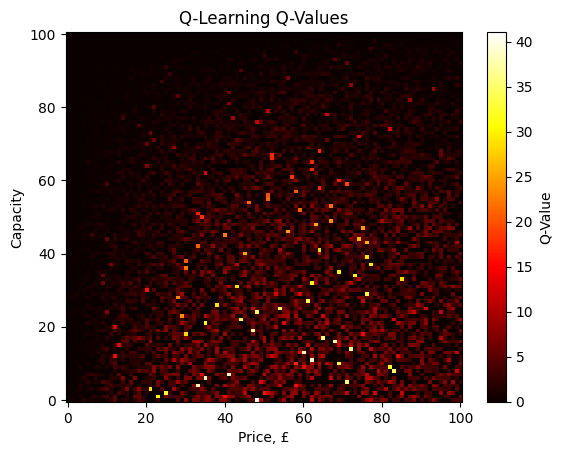

In [52]:
plt.imshow(q_table, cmap='hot',aspect='auto',origin = 'lower')
plt.xlabel("Price, £")
plt.ylabel("Capacity")
plt.colorbar(label = 'Q-Value')
plt.title("Q-Learning Q-Values")
plt.show()

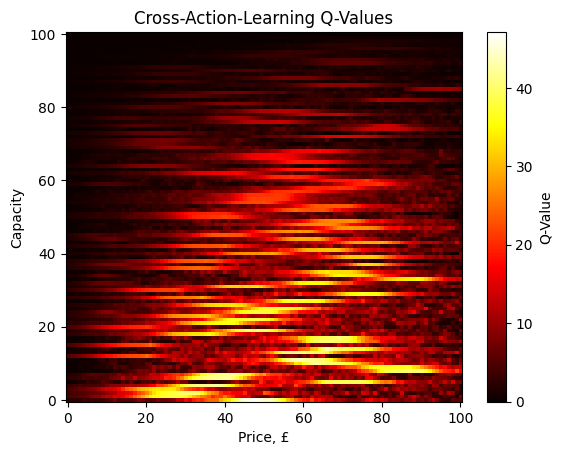

In [53]:
plt.imshow(q_table_aug_action, cmap='hot',aspect='auto',origin = 'lower')
plt.xlabel("Price, £")
plt.ylabel("Capacity")
plt.colorbar(label = 'Q-Value')
plt.title("Cross-Action-Learning Q-Values")
plt.show()

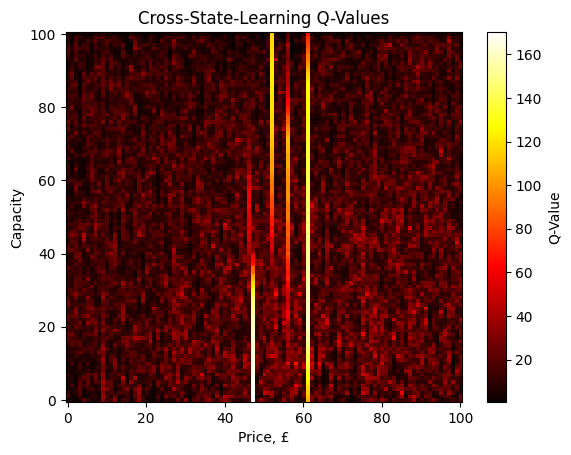

In [54]:
plt.imshow(q_table_aug_state, cmap='hot',aspect='auto',origin = 'lower')
plt.xlabel("Price, £")
plt.ylabel("Capacity")
plt.colorbar(label = 'Q-Value')
plt.title("Cross-State-Learning Q-Values")
plt.show()

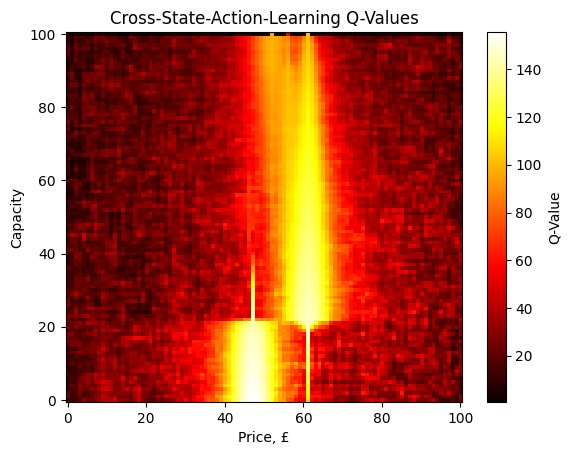

In [55]:
plt.imshow(q_table_aug_both, cmap='hot',aspect='auto',origin = 'lower')
plt.xlabel("Price, £")
plt.ylabel("Capacity")
plt.colorbar(label = 'Q-Value')
plt.title("Cross-State-Action-Learning Q-Values")
plt.show()

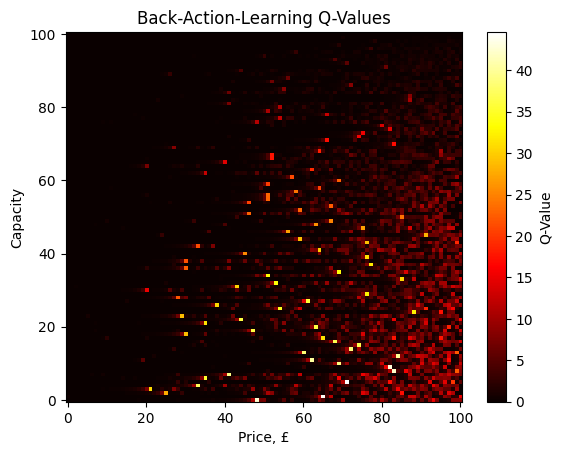

In [56]:
plt.imshow(q_table_back_action, cmap='hot',aspect='auto',origin = 'lower')
plt.xlabel("Price, £")
plt.ylabel("Capacity")
plt.colorbar(label = 'Q-Value')
plt.title("Back-Action-Learning Q-Values")
plt.show()

In [57]:
av_reward_norm = np.cumsum( [ np.mean(reward_norm[episode,:]) for episode in range(n_episodes) ] )
av_reward_aug_action = np.cumsum( [ np.mean(reward_aug_action[episode,:]) for episode in range(n_episodes) ] )
av_reward_aug_state = np.cumsum( [ np.mean(reward_aug_state[episode,:]) for episode in range(n_episodes) ] )
av_reward_aug_both = np.cumsum( [ np.mean(reward_aug_both[episode,:]) for episode in range(n_episodes) ] )
av_reward_back_action = np.cumsum( [ np.mean(reward_back_action[episode,:]) for episode in range(n_episodes) ] )


for rep in range(n_macro_reps):
    regret_norm[:,rep] = np.cumsum(regret_norm[:,rep])
    regret_aug_action[:,rep] = np.cumsum(regret_aug_action[:,rep])
    regret_aug_state[:,rep] = np.cumsum(regret_aug_state[:,rep])
    regret_aug_both[:,rep] = np.cumsum(regret_aug_both[:,rep])
    regret_back_action[:,rep] = np.cumsum(regret_back_action[:,rep])

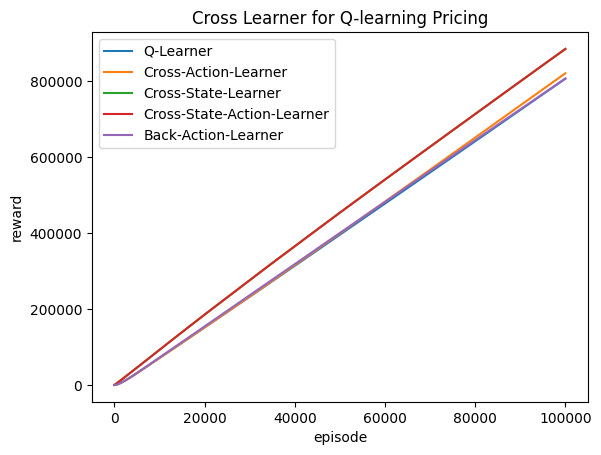

In [58]:
plt.plot(av_reward_norm,label ='Q-Learner')
plt.plot(av_reward_aug_action,label = 'Cross-Action-Learner')
plt.plot(av_reward_aug_state,label = 'Cross-State-Learner')
plt.plot(av_reward_aug_both,label = 'Cross-State-Action-Learner')
plt.plot(av_reward_back_action,label = 'Back-Action-Learner')
plt.xlabel("episode")
plt.ylabel("reward")
plt.title("Cross Learner for Q-learning Pricing")
plt.legend()
plt.show()

In [59]:
av_reg_norm = [np.mean(regret_norm[episode,:]) for episode in range(n_episodes)]
av_reg_aug_action = [np.mean(regret_aug_action[episode,:]) for episode in range(n_episodes)]
av_reg_aug_state = [np.mean(regret_aug_state[episode,:]) for episode in range(n_episodes)]
av_reg_aug_both = [np.mean(regret_aug_both[episode,:]) for episode in range(n_episodes)]
av_reg_back_action = [np.mean(regret_back_action[episode,:]) for episode in range(n_episodes)]

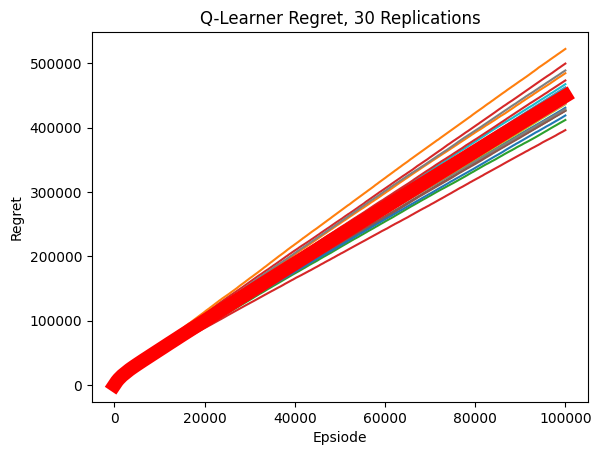

In [60]:
for rep in range(n_macro_reps):
    plt.plot(regret_norm[:,rep])
plt.plot(av_reg_norm,color ='red',linewidth = 10)
plt.xlabel("Epsiode")
plt.ylabel("Regret")
plt.title("Q-Learner Regret, 30 Replications")
plt.show()

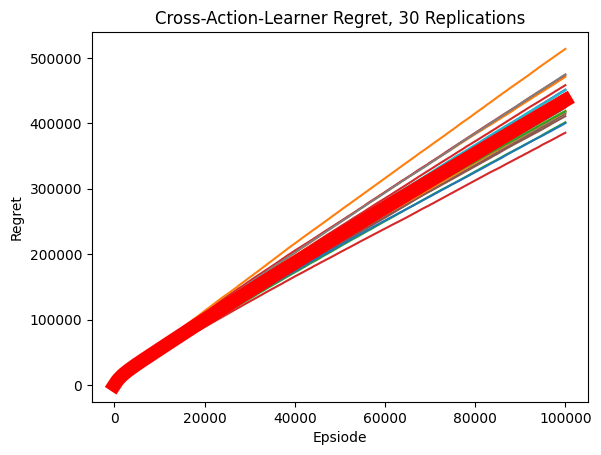

In [61]:
for rep in range(n_macro_reps):
    plt.plot(regret_aug_action[:,rep])
plt.plot(av_reg_aug_action,color ='red',linewidth = 10)
plt.xlabel("Epsiode")
plt.ylabel("Regret")
plt.title("Cross-Action-Learner Regret, 30 Replications")
plt.show()

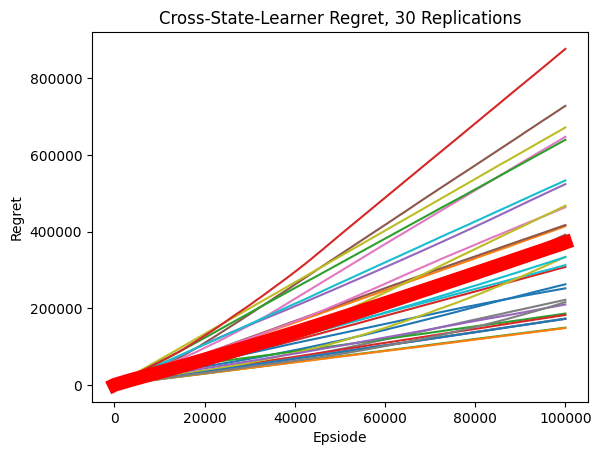

In [62]:
for rep in range(n_macro_reps):
    plt.plot(regret_aug_state[:,rep])
plt.plot(av_reg_aug_state,color ='red',linewidth = 10)
plt.xlabel("Epsiode")
plt.ylabel("Regret")
plt.title("Cross-State-Learner Regret, 30 Replications")
plt.show()

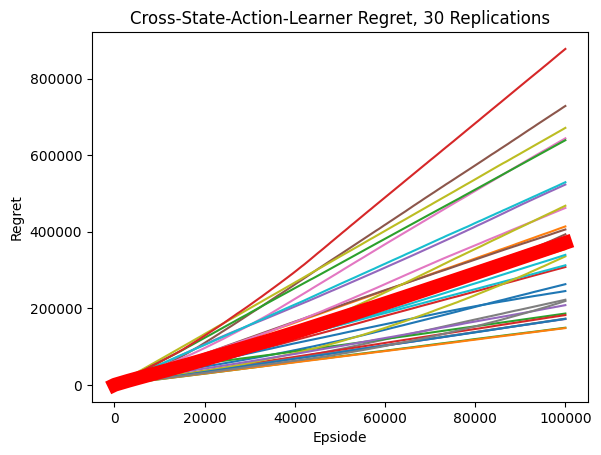

In [63]:
for rep in range(n_macro_reps):
    plt.plot(regret_aug_both[:,rep])
plt.plot(av_reg_aug_both,color ='red',linewidth = 10)
plt.xlabel("Epsiode")
plt.ylabel("Regret")
plt.title("Cross-State-Action-Learner Regret, 30 Replications")
plt.show()

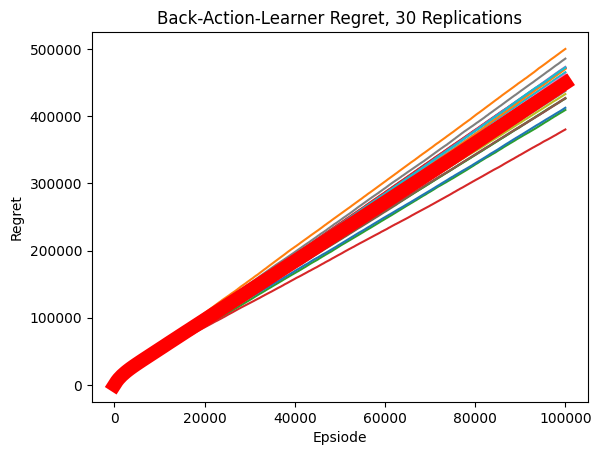

In [64]:
for rep in range(n_macro_reps):
    plt.plot(regret_back_action[:,rep])
plt.plot(av_reg_back_action,color ='red',linewidth = 10)
plt.xlabel("Epsiode")
plt.ylabel("Regret")
plt.title("Back-Action-Learner Regret, 30 Replications")
plt.show()

In [65]:
percent10 = [(i/10)*(100/101) for i in range(n_episodes)]

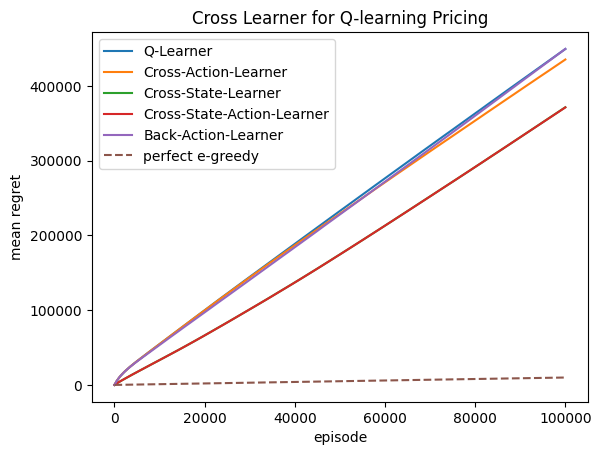

In [66]:
plt.plot(av_reg_norm,label ='Q-Learner')
plt.plot(av_reg_aug_action,label = 'Cross-Action-Learner')
plt.plot(av_reg_aug_state,label = 'Cross-State-Learner')
plt.plot(av_reg_aug_both,label = 'Cross-State-Action-Learner')
plt.plot(av_reg_back_action,label = 'Back-Action-Learner')
plt.plot(percent10, linestyle = "--", label = "perfect e-greedy")
plt.xlabel("episode")
plt.ylabel("mean regret")
plt.title("Cross Learner for Q-learning Pricing")
plt.legend()
plt.show()

In [67]:
var_reg_norm = [np.var(regret_norm[episode,:]) for episode in range(n_episodes)]
var_reg_aug_action = [np.var(regret_aug_action[episode,:]) for episode in range(n_episodes)]
var_reg_aug_state = [np.var(regret_aug_state[episode,:]) for episode in range(n_episodes)]
var_reg_aug_both = [np.var(regret_aug_both[episode,:]) for episode in range(n_episodes)]
var_reg_back_action = [np.var(regret_back_action[episode,:]) for episode in range(n_episodes)]

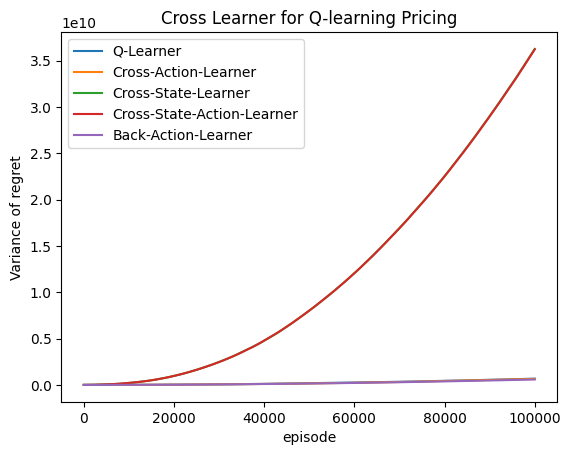

In [68]:
plt.plot(var_reg_norm,label ='Q-Learner')
plt.plot(var_reg_aug_action,label = 'Cross-Action-Learner')
plt.plot(var_reg_aug_state,label = 'Cross-State-Learner')
plt.plot(var_reg_aug_both,label = 'Cross-State-Action-Learner')
plt.plot(var_reg_back_action,label = 'Back-Action-Learner')
plt.xlabel("episode")
plt.ylabel("Variance of regret")
plt.title("Cross Learner for Q-learning Pricing")
plt.legend()
plt.show()

In [69]:
zvalue = scipy.stats.norm.ppf(0.975)

CI_upper_norm = [av_reg_norm[episode] + zvalue*((var_reg_norm[episode]/n_macro_reps)**(1/2)) for episode in range(n_episodes)]
CI_lower_norm = [av_reg_norm[episode] - zvalue*((var_reg_norm[episode]/n_macro_reps)**(1/2)) for episode in range(n_episodes)]

CI_upper_aug_action = [av_reg_aug_action[episode] + zvalue*((var_reg_aug_action[episode]/n_macro_reps)**(1/2)) for episode in range(n_episodes)]
CI_lower_aug_action = [av_reg_aug_action[episode] - zvalue*((var_reg_aug_action[episode]/n_macro_reps)**(1/2)) for episode in range(n_episodes)]

CI_upper_aug_state = [av_reg_aug_state[episode] + zvalue*((var_reg_aug_state[episode]/n_macro_reps)**(1/2)) for episode in range(n_episodes)]
CI_lower_aug_state = [av_reg_aug_state[episode] - zvalue*((var_reg_aug_state[episode]/n_macro_reps)**(1/2)) for episode in range(n_episodes)]

CI_upper_aug_both = [av_reg_aug_both[episode] + zvalue*((var_reg_aug_both[episode]/n_macro_reps)**(1/2)) for episode in range(n_episodes)]
CI_lower_aug_both = [av_reg_aug_both[episode] - zvalue*((var_reg_aug_both[episode]/n_macro_reps)**(1/2)) for episode in range(n_episodes)]

CI_upper_back_action = [av_reg_back_action[episode] + zvalue*((var_reg_back_action[episode]/n_macro_reps)**(1/2)) for episode in range(n_episodes)]
CI_lower_back_action = [av_reg_back_action[episode] - zvalue*((var_reg_back_action[episode]/n_macro_reps)**(1/2)) for episode in range(n_episodes)]

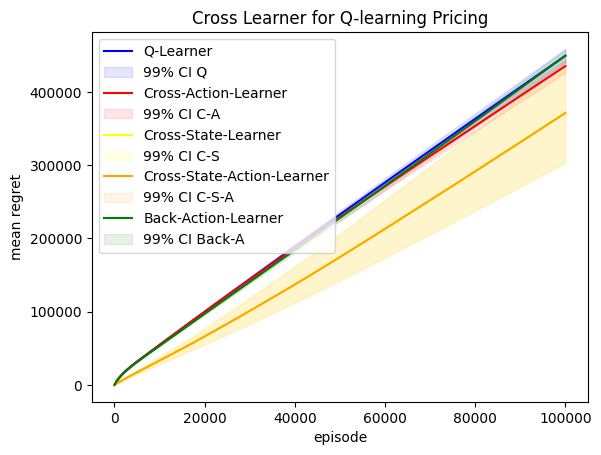

In [70]:
plt.plot(av_reg_norm,label ='Q-Learner',color= 'blue')
plt.fill_between(range(n_episodes),CI_lower_norm,CI_upper_norm,color= 'blue',alpha=0.1,label = '99% CI Q')

plt.plot(av_reg_aug_action,label = 'Cross-Action-Learner',color='red')
plt.fill_between(range(n_episodes),CI_lower_aug_action,CI_upper_aug_action,color='red',alpha=0.1,label = '99% CI C-A')

plt.plot(av_reg_aug_state,label = 'Cross-State-Learner',color='yellow')
plt.fill_between(range(n_episodes),CI_lower_aug_state,CI_upper_aug_state,color='yellow',alpha=0.1,label = '99% CI C-S')

plt.plot(av_reg_aug_both,label = 'Cross-State-Action-Learner',color='orange')
plt.fill_between(range(n_episodes),CI_lower_aug_both,CI_upper_aug_both,color='orange',alpha=0.1,label = '99% CI C-S-A')

plt.plot(av_reg_back_action,label = 'Back-Action-Learner',color = 'green')
plt.fill_between(range(n_episodes),CI_lower_back_action,CI_upper_back_action,color = 'green',alpha=0.1,label = '99% CI Back-A')


# plt.plot(percent10, linestyle = "--", label = "perfect e-greedy")
plt.xlabel("episode")
plt.ylabel("mean regret")
plt.title("Cross Learner for Q-learning Pricing")
plt.legend()
plt.show()
#plt.fill_between(range(n_episodes),CI_lower_norm,CI_upper_norm,color=(255/255,145/255,129/255),label = '95% CI Q')